In [1]:
import nltk

# first run ? => remove comment and download all
# placer le dossier téléchargé (nltk_data) dans le dossier '.env' (environnement virtuel)
# nltk.download()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import pickle

from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import preprocessing
from sklearn.svm import SVC
# from sklearn import utils

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier

Chargement du dataset

In [3]:
allocine_df = pd.read_pickle("./dataset_allocine.pickle")
allocine_df.head()

,commentaire,note
0,Décevant !<br/>Napoléon vu par Ridley Scott es...,1.0
1,Ça se laisse voir sans grand ennui mais pour q...,2.0
2,Succession de cartes postales sympathiques san...,1.0
3,"Film politisé et non-objectif, qui personnifie...",1.5
4,Ce film est une insulte à l'égard du peuple fr...,1.0


Distribution des notes

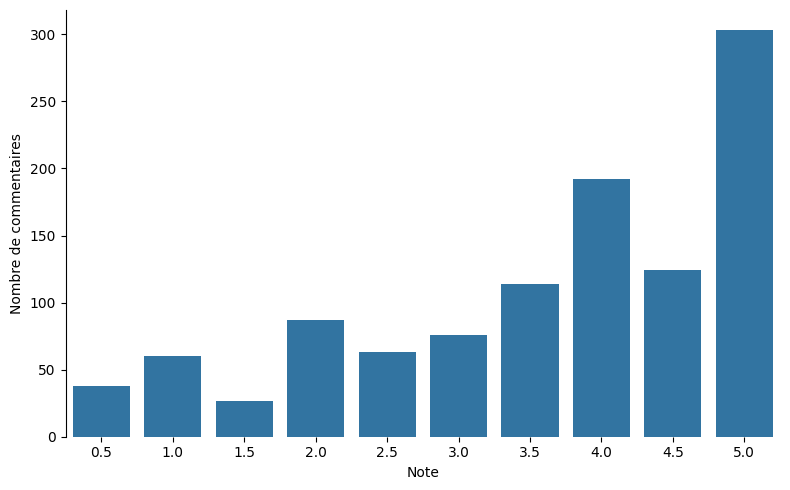

In [4]:
plt.figure(figsize=(8,5))

ax = sns.countplot(data=allocine_df, x='note')
ax.set(xlabel='Note', ylabel='Nombre de commentaires')

# Mise en forme finale du graphique
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Sauvegarde du graphique
# fig = ax.get_figure()
# fig.savefig('images/distribution_notes.png', dpi=200)

Retirer les éléments de ponctuation

In [5]:
REMPLACE_SANS_ESPACE = re.compile("[;:!\'?,\"()\[\]]|<br\s*/>")
REMPLACE_AVEC_ESPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|[.]")
PUR_NOMBRE = re.compile("[0-9]")

def preprocess_reviews(reviews):
    reviews = [PUR_NOMBRE.sub("", line.lower()) for line in reviews] # retire les nomre (comme les années)
    reviews = [line.replace('\n', ' ')  for line in reviews] # Retire les \n (retours chariots)
    reviews = [REMPLACE_SANS_ESPACE.sub("", line.lower()) for line in reviews]
    reviews = [REMPLACE_AVEC_ESPACE.sub(" ", line) for line in reviews]
    return reviews

allocine_df['commentaire'] = pd.DataFrame(preprocess_reviews(allocine_df['commentaire']))

allocine_df.head()

,commentaire,note
0,décevant napoléon vu par ridley scott est à la...,1.0
1,ça se laisse voir sans grand ennui mais pour q...,2.0
2,succession de cartes postales sympathiques san...,1.0
3,film politisé et non objectif qui personnifie ...,1.5
4,ce film est une insulte à légard du peuple fra...,1.0


Retirer les mots inutiles

In [6]:
french_stopwords = set(stopwords.words('french'))
filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]

allocine_df['commentaire'] = [' '.join(filtre_stopfr(word_tokenize(item))) for item in allocine_df['commentaire']]

allocine_df.head()

,commentaire,note
0,décevant napoléon vu ridley scott hauteur esti...,1.0
1,ça laisse voir sans grand ennui quelqu ’ aime ...,2.0
2,succession cartes postales sympathiques sans p...,1.0
3,film politisé non objectif personnifie napoléo...,1.5
4,film insulte légard peuple français amateurs c...,1.0


'Stemmatisation'

In [7]:
# Exemple : `également` est transformé en `égal`

stemmer = FrenchStemmer()
allocine_df['commentaire'] = [stemmer.stem(w) for w in allocine_df['commentaire']]

allocine_df.head()

,commentaire,note
0,décevant napoléon vu ridley scott hauteur esti...,1.0
1,ça laisse voir sans grand ennui quelqu ’ aime ...,2.0
2,succession cartes postales sympathiques sans p...,1.0
3,film politisé non objectif personnifie napoléo...,1.5
4,film insulte légard peuple français amateurs c...,1.0


Vectorisation

In [8]:
labels = allocine_df.loc[:, allocine_df.columns != 'note']
targets = allocine_df.note

cv = CountVectorizer(binary=True)
cv.fit(labels["commentaire"])
labels_onehot = cv.transform(labels["commentaire"])

pd.DataFrame(labels_onehot.toarray())

,0,1,2,3,4,5,6,7,8,9,...,9643,9644,9645,9646,9647,9648,9649,9650,9651,9652
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Encodage des notes

In [9]:
lab = preprocessing.LabelEncoder()
targets_transformed = lab.fit_transform(targets)

targets_transformed

array([1, 3, 1, ..., 9, 9, 8])

Equilibrer le dataset

In [10]:
seed = 100
k = 1

sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
labels_res, targets_res = sm.fit_resample(labels_onehot, targets_transformed)

In [11]:
print("labels_res.shape : ", labels_res.shape)
print("targets_res.shape : ", targets_res.shape)

labels_res.shape :  (3030, 9653)
targets_res.shape :  (3030,)


Distribution des notes après équilibrage du dataset

In [12]:
df_target_res = pd.DataFrame(lab.inverse_transform(targets_res), columns =["note"])
df_labels_res = pd.DataFrame(np.zeros(targets_res.shape[0]), columns =["index commentaire"])

balanced_allocine_df = pd.concat([df_labels_res, df_target_res], axis=1)

balanced_allocine_df.head()

,index commentaire,note
0,0.0,1.0
1,0.0,2.0
2,0.0,1.0
3,0.0,1.5
4,0.0,1.0


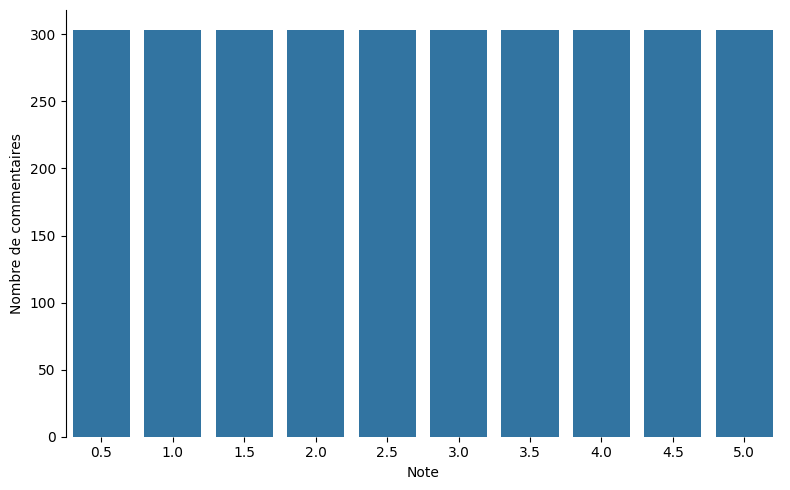

In [13]:
plt.figure(figsize=(8,5))

ax = sns.countplot(data=balanced_allocine_df, x='note')
ax.set(xlabel='Note', ylabel='Nombre de commentaires')

# Mise en forme finale du graphique
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Sauvegarde du graphique
# fig = ax.get_figure()
# fig.savefig('images/distribution_equilibre_notes.png', dpi=200)

Création des différents set de données (entraînement et validation)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(labels_res, targets_res, test_size=0.2, random_state=1)

In [15]:
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (2424, 9653)
x test:  (606, 9653)
y train:  (2424,)
y test:  (606,)


Entraînement du modèle

In [16]:
# Support Vector Machine Classifier

clf = SVC(kernel='linear', C=3)
clf.fit(x_train, y_train)

precision = round(round(accuracy_score(y_test, clf.predict(x_test)), 2) * 100)
print(f"{precision}%")

63%


In [17]:
# Logistic Regression

lo_r = LogisticRegression()
lo_r.fit(x_train, y_train)

precision = round(round(accuracy_score(y_test, lo_r.predict(x_test)), 2) * 100)
print(f"{precision}%")

64%


In [18]:
# Neural Network

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(x_train, y_train)


predict_train = mlp.predict(x_train)
predict_test = mlp.predict(x_test)

print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[230   0  11   0   0   0   0   0   0   0]
 [ 39 156  25   8   0   0   0   0   6   0]
 [ 25   0 216   0   0   0   0   0   0   0]
 [ 28  10  11 182   8   0   0   0   0   0]
 [ 33   0  25   0 190   0   2   0   0   0]
 [ 36   0  10   0   0 200   0   0   0   0]
 [ 13   0   4   0   8   0 218   1   3   0]
 [  8   0   1   0   3   6   5 209   3   0]
 [ 11   0   0   0   1   0   1   2 232   0]
 [  0   0   0   0   0   0   0   0   0 244]]
              precision    recall  f1-score   support

           0       0.54      0.95      0.69       241
           1       0.94      0.67      0.78       234
           2       0.71      0.90      0.79       241
           3       0.96      0.76      0.85       239
           4       0.90      0.76      0.83       250
           5       0.97      0.81      0.88       246
           6       0.96      0.88      0.92       247
           7       0.99      0.89      0.94       235
           8       0.95      0.94      0.95       247
           9       1.00     

Sauvegarde du modèle

In [19]:
# save the model to disk
filename = 'model.sav'
pickle.dump(mlp, open(filename, 'wb'))